In [1]:
# ============================================================
# SECTION 1: IMPORT LIBRARIES
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional: display settings for notebook
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")


In [2]:
# ============================================================
# SECTION 2: LOAD DATASET
# ============================================================

# Load raw dataset
df_raw = pd.read_csv("dataset/loan.csv", low_memory=False)

# Select business-relevant columns
cols = [
    'loan_amnt',
    'term',
    'int_rate',
    'grade',
    'emp_length',
    'annual_inc',
    'loan_status',
    'issue_d'
]

df = df_raw[cols].copy()

# Basic inspection
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (2260668, 8)


,loan_amnt,term,int_rate,grade,emp_length,annual_inc,loan_status,issue_d
0,2500,36 months,13.56,C,10+ years,55000.0,Current,Dec-2018
1,30000,60 months,18.94,D,10+ years,90000.0,Current,Dec-2018
2,5000,36 months,17.97,D,6 years,59280.0,Current,Dec-2018
3,4000,36 months,18.94,D,10+ years,92000.0,Current,Dec-2018
4,30000,60 months,16.14,C,10+ years,57250.0,Current,Dec-2018


In [3]:
# ============================================================
# SECTION 3: DATA CLEANING & TARGET CREATION
# ============================================================

import os
os.makedirs("output", exist_ok=True)

# Convert issue date
df['issue_d'] = pd.to_datetime(
    df['issue_d'].str.strip(),
    format='%b-%Y',
    errors='coerce'
)

# Convert numeric columns
df['loan_amnt'] = pd.to_numeric(df['loan_amnt'], errors='coerce')
df['annual_inc'] = pd.to_numeric(df['annual_inc'], errors='coerce')
df['int_rate'] = pd.to_numeric(df['int_rate'], errors='coerce')

# Extract numeric term
df['term'] = df['term'].str.extract(r'(\d+)').astype(float)

# Extract employment length
df['emp_length'] = df['emp_length'].str.extract(r'(\d+)')
df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')

# Handle missing values
df['annual_inc'] = df['annual_inc'].fillna(df['annual_inc'].median())
df['emp_length'] = df['emp_length'].fillna(df['emp_length'].median())

# Create target variable
df['default_flag'] = df['loan_status'].isin(
    ['Charged Off', 'Default']
).astype(int)

# Drop critical missing rows
df = df.dropna(subset=['loan_amnt', 'int_rate', 'term', 'grade'])

# Sort by time
df = df.sort_values('issue_d')

# Save cleaned dataset
df.to_csv("output/cleaned_dataset.csv", index=False)

# Quick checks
print("Cleaned shape:", df.shape)
print("Default rate:", round(df['default_flag'].mean(), 4))

df.head()


Cleaned shape: (2260668, 9)
Default rate: 0.1158


,loan_amnt,term,int_rate,grade,emp_length,annual_inc,loan_status,issue_d,default_flag
2142001,1400,36.0,10.91,C,1.0,40000.0,Does not meet the credit policy. Status:Fully ...,2007-06-01,0
2142017,2525,36.0,9.33,B,1.0,110000.0,Does not meet the credit policy. Status:Fully ...,2007-06-01,0
2142016,1000,36.0,9.64,B,1.0,12000.0,Does not meet the credit policy. Status:Fully ...,2007-06-01,0
2142015,3500,36.0,10.28,C,1.0,180000.0,Does not meet the credit policy. Status:Fully ...,2007-06-01,0
2142014,6500,36.0,9.64,B,1.0,20000.0,Does not meet the credit policy. Status:Charge...,2007-06-01,0


Overall Default Rate: 11.58 %


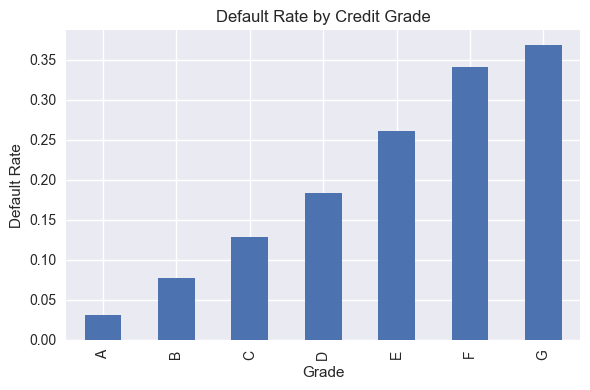

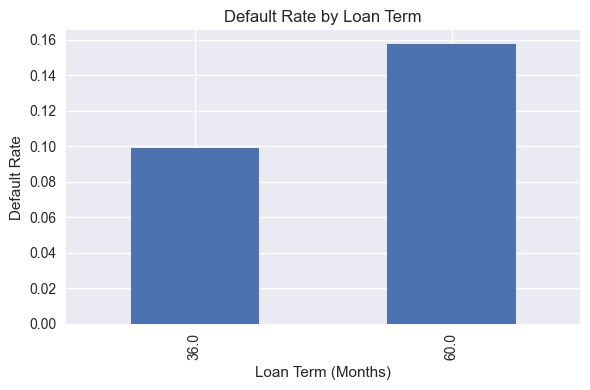

In [4]:
# ============================================================
# SECTION 4: EXPLORATORY DATA ANALYSIS
# ============================================================

import os
os.makedirs("output", exist_ok=True)

# Overall default rate
overall_default_rate = df['default_flag'].mean()
print("Overall Default Rate:", round(overall_default_rate * 100, 2), "%")


# -----------------------------
# Default rate by credit grade
# -----------------------------

default_by_grade = df.groupby('grade')['default_flag'].mean().sort_index()

plt.figure(figsize=(6,4))
default_by_grade.plot(kind='bar')
plt.title("Default Rate by Credit Grade")
plt.ylabel("Default Rate")
plt.xlabel("Grade")
plt.tight_layout()
plt.savefig("output/default_by_grade.png")
plt.show()


# -----------------------------
# Default rate by loan term
# -----------------------------

default_by_term = df.groupby('term')['default_flag'].mean()

plt.figure(figsize=(6,4))
default_by_term.plot(kind='bar')
plt.title("Default Rate by Loan Term")
plt.ylabel("Default Rate")
plt.xlabel("Loan Term (Months)")
plt.tight_layout()
plt.savefig("output/default_by_term.png")
plt.show()


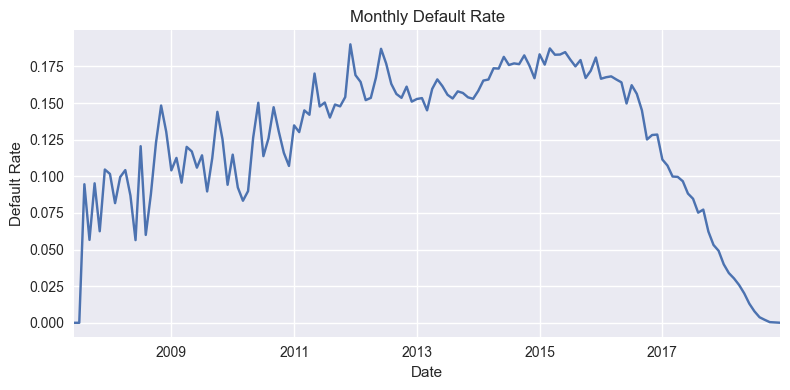

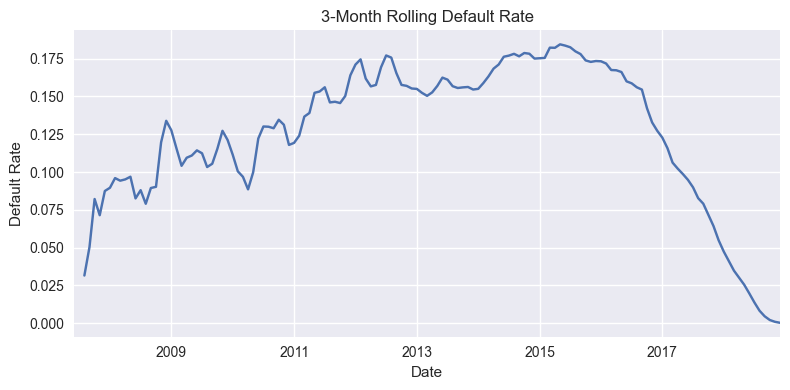

In [5]:
# ============================================================
# SECTION 5: TIME-SERIES ANALYSIS
# ============================================================

# Ensure datetime index
df_ts = df.set_index('issue_d').sort_index()

# -----------------------------
# Monthly Default Rate
# -----------------------------

monthly_default = df_ts['default_flag'].resample('ME').mean()

plt.figure(figsize=(8,4))
monthly_default.plot()
plt.title("Monthly Default Rate")
plt.ylabel("Default Rate")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("output/monthly_default.png")
plt.show()


# -----------------------------
# 3-Month Rolling Average
# -----------------------------

rolling_default = monthly_default.rolling(3).mean()

plt.figure(figsize=(8,4))
rolling_default.plot()
plt.title("3-Month Rolling Default Rate")
plt.ylabel("Default Rate")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("output/rolling_default.png")
plt.show()


In [6]:
# ============================================================
# SECTION 6: FEATURE ENGINEERING & TRAIN-TEST SPLIT
# ============================================================

# Feature Engineering
df['income_to_loan_ratio'] = df['annual_inc'] / df['loan_amnt']
df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month

# Feature Selection
features = [
    'loan_amnt',
    'term',
    'int_rate',
    'annual_inc',
    'emp_length',
    'income_to_loan_ratio',
    'issue_year',
    'issue_month',
    'grade'
]

X = df[features]
y = df['default_flag']

# Time-based Train-Test Split
split_date = df['issue_d'].quantile(0.8)

X_train = X[df['issue_d'] <= split_date]
X_test = X[df['issue_d'] > split_date]

y_train = y[df['issue_d'] <= split_date]
y_test = y[df['issue_d'] > split_date]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("\nDefault rate in train:", round(y_train.mean(), 4))
print("Default rate in test:", round(y_test.mean(), 4))


Train shape: (1834519, 9)
Test shape: (426149, 9)

Default rate in train: 0.1403
Default rate in test: 0.0103


In [7]:
# ============================================================
# SECTION 7: PREPROCESSING + LOGISTIC REGRESSION
# ============================================================

# Define categorical and numeric features
categorical_features = ['grade']
numeric_features = [col for col in features if col != 'grade']

# Preprocessing pipeline (Scaling + OneHot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Logistic Regression with class balancing
log_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        random_state=42
    ))
])

# Train model
log_model.fit(X_train, y_train)

# Predictions
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.99      0.83      0.91    421762
           1       0.03      0.41      0.05      4387

    accuracy                           0.83    426149
   macro avg       0.51      0.62      0.48    426149
weighted avg       0.98      0.83      0.90    426149

ROC-AUC: 0.7169640887536378


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    421762
           1       0.03      0.00      0.01      4387

    accuracy                           0.99    426149
   macro avg       0.51      0.50      0.50    426149
weighted avg       0.98      0.99      0.98    426149

ROC-AUC: 0.6697564652694933


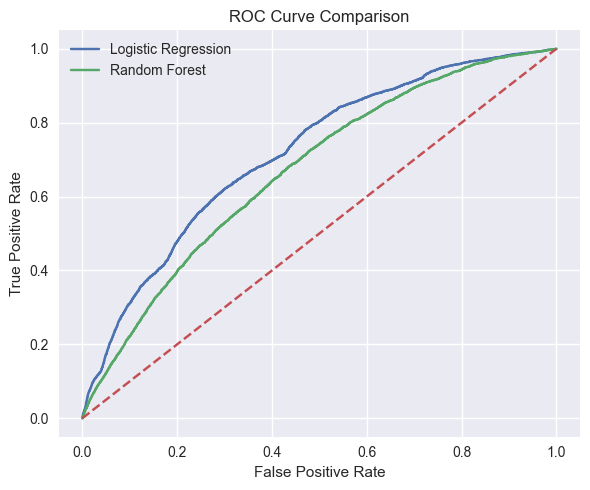

In [8]:
# ============================================================
# SECTION 8: RANDOM FOREST + ROC CURVE
# ============================================================

# Random Forest with class balancing
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])


# Train model
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


# -----------------------------
# ROC Curve Comparison
# -----------------------------

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("output/roc_curve.png")
plt.show()


In [10]:
# ============================================================
# SECTION 9: FEATURE IMPORTANCE (RANDOM FOREST)
# ============================================================

# Extract trained RF classifier
rf_classifier = rf_model.named_steps['classifier']

# Get feature names after preprocessing
feature_names = (
    numeric_features +
    list(
        rf_model.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(['grade'])
    )
)

# Get importances
importances = rf_classifier.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Show top 10
print("\nTop 10 Important Features:")
print(importance_df.head(10))





Top 10 Important Features:
                 feature  importance
2               int_rate    0.274441
6             issue_year    0.156569
8                grade_A    0.109557
5   income_to_loan_ratio    0.088460
3             annual_inc    0.070990
0              loan_amnt    0.056098
9                grade_B    0.047730
12               grade_E    0.037534
7            issue_month    0.034716
4             emp_length    0.026917
